In [1]:
import numpy as np
import theano
import theano.tensor as T

In [63]:
def single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt, exp):
    Area = np.pi * D**2.0 / 4.0
    m = 1.0 / (sqrt(1.0 - CT))
    k = sqrt((m + 1.0) / 2.0)
    R96 = a1 * (exp(a2 * CT * CT + a3 * CT + a4)) * (b1 * TI + b2) * D
    x0 = (9.6 * D) / ((2.0 * R96 / (k * D))**3.0 - 1.0)
    term1 = (k * D / 2.0)**2.5
    term2 = (105.0/(2.0*np.pi))**-0.5
    term3 = (CT * Area * x0)**(-5.0 / 6.0)
    c1 = term1 * term2 * term3
    Rw = ((105.0 * c1**2.0 / (2.0 * np.pi))**0.2) * (CT * Area * (x + x0))**(1.0 / 3.0)
    term10=(1./9.)
    term20=(CT*Area*(x+x0)**(-2.))**(1./3.)
    term310=(r**(1.5))
    term320=(3.*c1*c1*CT*Area*(x+x0))**(-0.5)
    term30=term310*term320
    term41=(35./(2.*np.pi))**(3./10.)
    term42=(3.*c1*c1)**(-0.2)
    term40=term41*term42
    dU1=-term10*term20*(term30-term40)**2.
    dU = dU1
    dU[Rw<r]=0.0
    dU[X_<0.0]=0.0
    return dU, Rw

In [64]:
# gcl = theano.function(inputs=[x, r, CT, TI, D, a1, a2, a3, a4, b1, b2], outputs=[dU, Rw])
D, TI, CT, x, r = T.dvectors("D", "TI", "CT", "x", "r")
#a1, a2, a3, a4, b1, b2 = T.dvectors("a1", "a2", "a3", "a4", "b1", "b2")
a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]

dU, Rw = single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=T.sqrt, exp=T.exp)
gcl_theano = theano.function([x, r, CT, TI, D], [dU, Rw])

TypeError: 'TensorVariable' object does not support item assignment

In [38]:
gcl_numpy = lambda x, r, D, TI, CT: single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=np.sqrt, exp=np.exp)

In [58]:
wt_D = 80.0
N = 1000
xs = np.linspace(-2, 10, N) * wt_D
rs = np.linspace(-3, 3, N) * wt_D
x, r = np.meshgrid(xs, rs)
X_ = x.flatten()
R_ = abs(r.flatten())
D_ = wt_D * np.ones_like(X_)
CT_ = 0.80 * np.ones_like(X_)
TI_ = 0.01 * np.ones_like(X_)
#a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]
#a1 *= np.ones_like(x)
#a2 *= np.ones_like(x)
#a3 *= np.ones_like(x)
#b1 *= np.ones_like(x)
#b2 *= np.ones_like(x)

In [59]:
%%timeit
gcl_theano(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 389 ms per loop


In [60]:
%%timeit
gcl_numpy(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 206 ms per loop


In [62]:
X_.size

1000000

In [61]:
dU, Rw = gcl_theano(X_, R_, CT_, TI_, D_)
dU[Rw<R_]=0.0
dU[X_<0.0]=0.0

In [51]:
DU = dU.reshape(x.shape)

In [52]:
from matplotlib import pylab as plt
%matplotlib inline

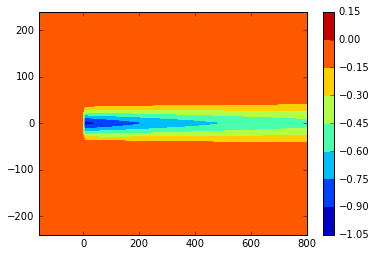

In [53]:
plt.contourf(xs, rs, DU)
plt.colorbar()

In [25]:
DU

array([[  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       ..., 
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan]])

In [68]:
def power_of_2(previous_power, max_value):
    return previous_power*2, theano.scan_module.until(previous_power*2 > max_value)

max_value = T.scalar()
values, _ = theano.scan(power_of_2,
                        outputs_info = T.constant(4.),
                        non_sequences = max_value,
                        n_steps = 1024)

f = theano.function([max_value], values)

print(f(45))

[  8.  16.  32.  64.]


In [ ]:
def march(U, CT)